In [1]:
import pandas as pd
import numpy as np

import re
import string
# BERT-Embeddings
from keybert import KeyBERT
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
#import altair as alt
#alt.renderers.enable('mimetype')
from sklearn.metrics.pairwise import cosine_similarity

/home/haochenyang/personal/miniconda3/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-03 23:10:01.425756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 23:10:02.228767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Similarity between two books by TF-IDF
## TF-IDF

1. USE keyBERT to extract the relevant keywords from the Description of the book.
2. Use TF-IDF to calculate the similarity between the keywords

# 1.TF-IDF

In [2]:
books_data = pd.read_csv('preprocess_book.csv')[:5000]
books_data["keywords"] = books_data[['features', 'keywords']].fillna('').agg(' '.join, axis=1)

In [3]:
books_data.head(5)

,Unnamed: 0,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber,keywords,features
0,0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151,niccolò_machiavelli university_of_chicago_pres...,niccolò_machiavelli university_of_chicago_press
1,1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384,william_h._willimon duke_university_press_book...,william_h._willimon duke_university_press_books
2,3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400,john_henry_newman yale_university_press schola...,john_henry_newman yale_university_press
3,4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622,ronald_l._numbers johns_hopkins_university_pre...,ronald_l._numbers johns_hopkins_university_press
4,6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146,timothy_matovina university_of_texas_press ala...,timothy_matovina university_of_texas_press


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8', 
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(books_data["keywords"])

In [5]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[0:150])

['1605' '1776' '1812' '1863' '1914' '1916' '1920s' '1930s' '1939' '1941'
 '1942' '1944' '1945' '1948' '1950s' '1960s' '1980s' '3d' 'a.l._rowse'
 'abbeville_press' 'abigail' 'abingdon_press' 'abolitionist' 'abortion'
 'abraham' 'abrams' 'abuse' 'abused' 'academic' 'academic_press'
 'accessories' 'accident' 'accused' 'ace' 'ace_books' 'acting' 'activism'
 'activist' 'activists' 'activities' 'actor' 'actors' 'actress'
 'acupuncture' 'ada' 'adams_media' 'addiction'
 'addison_wesley_publishing_company' 'admiral' 'adolescence' 'adolescent'
 'adolescents' 'adolf' 'adolph_l._reed_jr.' 'adornos' 'adulthood'
 'adventure' 'adventurers' 'adventures' 'aegypan' 'aesthetic' 'affair'
 'afghan' 'africa' 'african' 'africanamerican' 'africanamericans'
 'africans' 'africas' 'afterlife' 'agatha_christie' 'agenda' 'aging'
 'agnes' 'aids' 'aircraft' 'airlines' 'ak_press' 'aladdin' 'alaska'
 'albert_whitman__company' 'album' 'albums' 'alcoholic' 'alcoholics'
 'aldens' 'alex' 'alexander_mccall_smith' 'alfaguar

In [6]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=books_data["Name"], columns=tfidf.get_feature_names_out())
tfidf_df.head(5)

# tfidf_df

,1605,1776,1812,1863,1914,1916,1920s,1930s,1939,1941,...,york,youngest,youth,yves_got,zealand,zebra,zedong,zen,zondervan,zulu
Name,,,,,,,,,,,,,,,,,,,,,
the prince,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"sermons from duke chapel: voices from ""a great towering church""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the idea of a university,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
caring and curing: health and medicine in the western religious traditions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the alamo remembered: tejano accounts and perspectives,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
tfidf_df["total"]
del tfidf_df["total"]

In [8]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[:,20:].copy()
# print(tfidf_df_preview)
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
tfidf_df_preview

,book,term,tfidf
10819753,"""and then tiger told the shark..."": a collecti...",johnson,0.722306
10820738,"""and then tiger told the shark..."": a collecti...",sport,0.691573
10818438,"""and then tiger told the shark..."": a collecti...",abigail,0.000000
10818439,"""and then tiger told the shark..."": a collecti...",abingdon_press,0.000000
10818440,"""and then tiger told the shark..."": a collecti...",abolitionist,0.000000
...,...,...,...
12385024,多重人格探偵サイコ 1,abraham,0.000000
12385025,多重人格探偵サイコ 1,abrams,0.000000
12385026,多重人格探偵サイコ 1,abuse,0.000000
12385027,多重人格探偵サイコ 1,abused,0.000000


In [9]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]
    
    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())    
tfidf_vec.iloc[0:5]

,book,term,tfidf
10819753,"""and then tiger told the shark..."": a collecti...",johnson,0.722306
10820738,"""and then tiger told the shark..."": a collecti...",sport,0.691573
12157736,"""lady in the locker room""/uncovering the oakla...",susan,0.797039
12158075,"""lady in the locker room""/uncovering the oakla...",writer,0.603928
10605398,"'til death do us part (bailey weggins mystery,...",bailey,0.716875


In [10]:
import altair as alt
import pandas as pd

# 示例数据加载
# 假设 tfidf_vec 是一个包含以下列的 DataFrame：
# - 'book': 书名
# - 'term': 关键词
# - 'tfidf': TF-IDF 值

# 示例：从 DataFrame 中筛选每本书的前 10 个关键词
top_terms = (
    tfidf_vec.sort_values(by=['book', 'tfidf'], ascending=[True, False])
    .groupby('book')
    .head(5)  # 每本书只保留 TF-IDF 最高的前 10 个关键词
)

# 限制显示的书籍数量
filtered_books = top_terms['book'].unique()[20:50]  # 仅选择前 20 本书
top_terms = top_terms[top_terms['book'].isin(filtered_books)]

# 创建热力图
heatmap = alt.Chart(top_terms).mark_rect().encode(
    x=alt.X('term:N', title='Keywords', sort=None),  # 关键词作为 x 轴
    y=alt.Y('book:N', title='Books', sort=None),    # 书名作为 y 轴
    color=alt.Color('tfidf:Q', title='TF-IDF Value', scale=alt.Scale(scheme='redpurple'))  # 颜色代表 TF-IDF 值
).properties(
    width=600,  # 调整图表宽度
    height=400,  # 调整图表高度
    title='Top TF-IDF Keywords for Selected Books'  # 图表标题
)

# 添加文本标注
text = alt.Chart(top_terms).mark_text(
    align='center',
    baseline='middle',
    fontSize=12  # 更大的字体
).encode(
    x=alt.X('term:N', sort=None),
    y=alt.Y('book:N', sort=None),
    text=alt.Text('tfidf:Q', format='.2f'),  # 显示保留两位小数的 TF-IDF 值
    color=alt.condition(
        alt.datum.tfidf > 0.23, alt.value('white'), alt.value('black')  # 根据 TF-IDF 值调整文字颜色
    )
)

# 叠加热力图和文本
final_chart = (heatmap + text).properties(
    width=600,
    height=400
)

# 展示图表
final_chart

alt.LayerChart(...)

In [11]:
book_cosine_sim_tf = cosine_similarity(tfidf_encoding, tfidf_encoding)

In [12]:
np.save('book_cosine_sim_tf.npy', book_cosine_sim_tf)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
def plot_graph(book_cosine_sim, thresh=0.5):
# 设置更高的相似性阈值，进一步稀疏图
    threshold = thresh  # 提高阈值，筛选出更强的关系
    sparse_sim = (book_cosine_sim > threshold).astype(int)

    # 创建图对象
    G = nx.Graph()

    # 添加节点（书籍编号）
    G.add_nodes_from(range(len(book_cosine_sim)))

    # 添加边（仅保留相似性高于阈值的书籍对）
    for i in range(len(book_cosine_sim)):
        for j in range(i + 1, len(book_cosine_sim)):
            if sparse_sim[i, j] == 1:
                G.add_edge(i, j, weight=book_cosine_sim[i, j])

    # 进一步稀疏：只保留度数高的节点
    # 可选：过滤掉度数小于某个值的节点
    min_degree = 3  # 设置最低度数（节点至少需要一定数量的连接）
    G = G.subgraph([node for node, degree in G.degree() if degree >= min_degree])

    # 绘制网络图（仅显示部分节点，避免过于密集）
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # 使用 spring 布局

    # 节点
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.8)

    # 边
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v) for u, v, d in edges],
        width=[d['weight'] * 2 for u, v, d in edges],  # 调整边的宽度，使权重更明显
        alpha=0.5, edge_color='gray'
    )

    # 隐藏节点标签（可选）
    plt.title("Sparse Book Similarity Network (Higher Threshold) By TF-IDF", fontsize=16)
    plt.axis('off')
    plt.show()


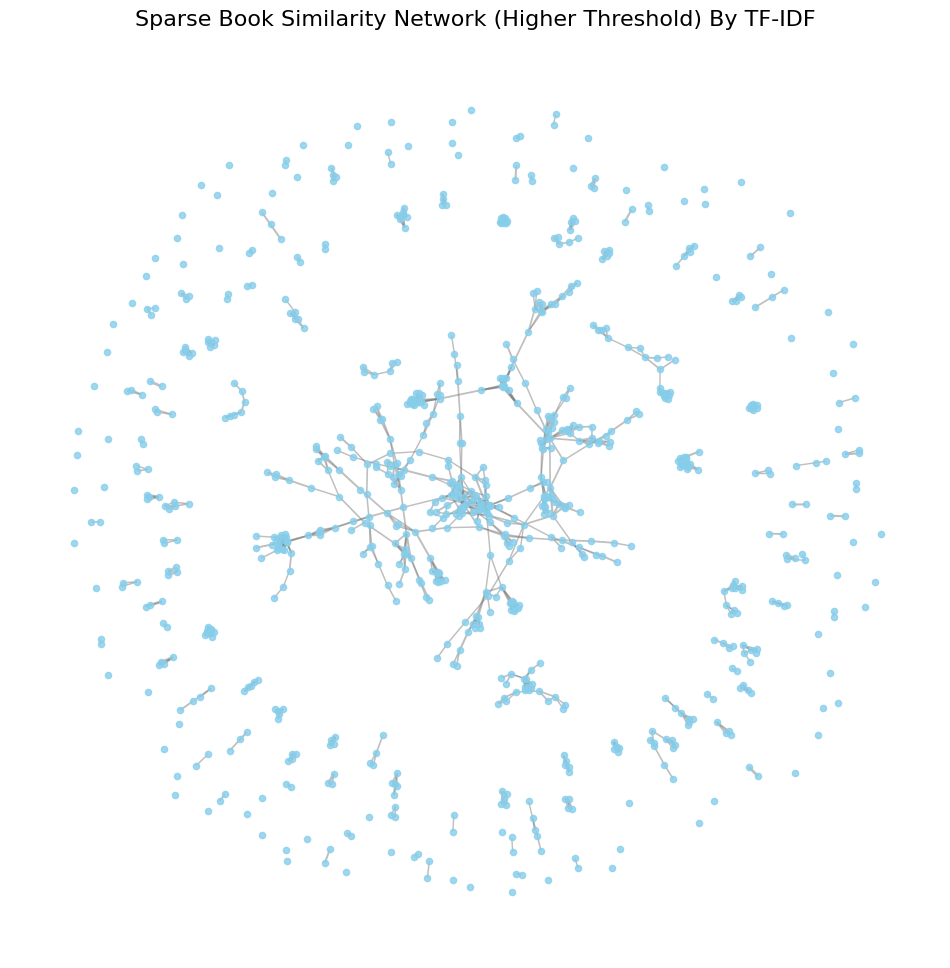

In [14]:
plot_graph(book_cosine_sim_tf)